# Time Series Transition Examples
This notebook demonstrates the `transition_ts` function to glue two time series with a smooth transition. We compare linear interpolation and PCHIP, with and without overlap.

In [3]:
import pandas as pd
import numpy as np
from scipy.interpolate import PchipInterpolator
from vtools import transition_ts
import matplotlib.pyplot as plt



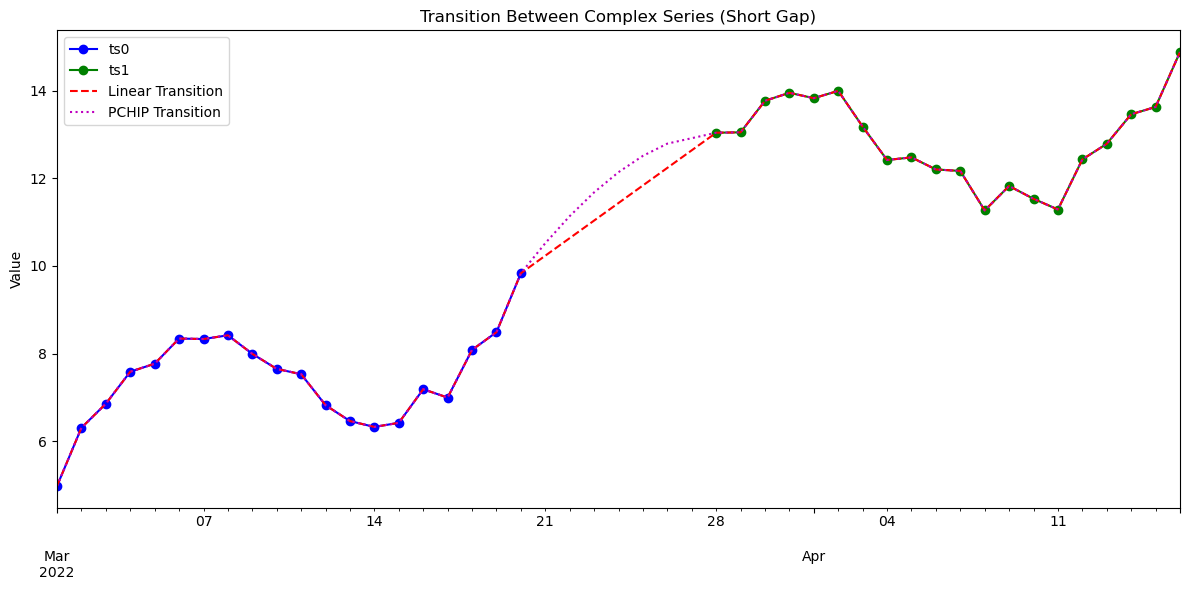

In [8]:
import numpy as np
date0 = pd.date_range("2022-03-01", periods=20, freq="d")
date1 = pd.date_range("2022-03-28", periods=20, freq="d")

# Seasonal + trend + noise
ts0 = pd.Series(5 + 0.25*np.arange(20) + 2*np.sin(np.linspace(0, 2*np.pi, 20)) + np.random.normal(0, 0.3, 20), index=date0)
ts1 = pd.Series(12 + 0.1*np.arange(20) + 1.5*np.sin(np.linspace(0, 2*np.pi, 20) + 0.5) + np.random.normal(0, 0.3, 20), index=date1)

# Transition over the 6-day gap between ts0 and ts1
glue_linear = transition_ts(ts0, ts1, method='linear', create_gap=["2022-03-21", "2022-03-26"], return_type='series')
glue_pchip = transition_ts(ts0, ts1, method='pchip', create_gap=["2022-03-21", "2022-03-26"], overlap=(3, 3), return_type='series')

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ts0.plot(ax=ax, style='bo-', label='ts0')
ts1.plot(ax=ax, style='go-', label='ts1')
glue_linear.plot(ax=ax, style='r--', label='Linear Transition')
glue_pchip.plot(ax=ax, style='m:', label='PCHIP Transition')
ax.legend()
ax.set_title("Transition Between Complex Series (Short Gap)")
ax.set_ylabel("Value")
plt.tight_layout()
plt.show()

plotting


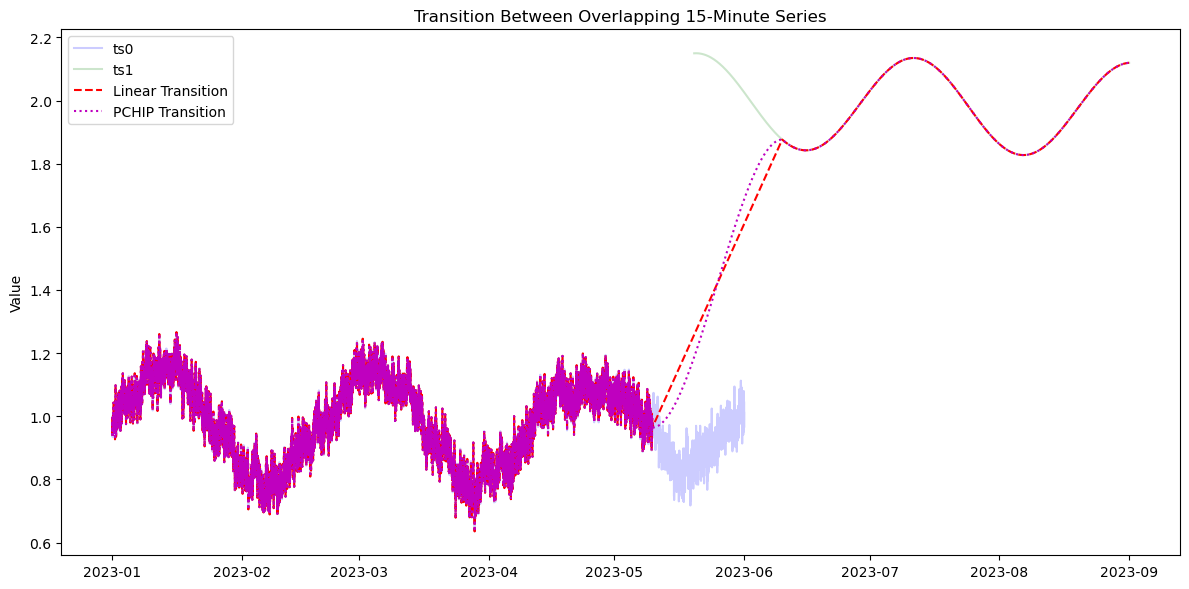

In [9]:
import numpy as np
def pink_noise(size, alpha=1.0):
    f = np.fft.rfftfreq(size)
    f[0] = 1e-6  # avoid division by zero
    spectrum = 1 / f**(alpha / 2.0)
    phases = np.exp(2j * np.pi * np.random.rand(len(f)))
    signal = np.fft.irfft(spectrum * phases, n=size)
    return signal / np.std(signal)


# Create overlapping 15-minute time series
date0 = pd.date_range("2023-01-01 00:00", "2023-06-01 00:00", freq="15min")
date1 = pd.date_range("2023-05-20 01:30", "2023-09-01 00:00", freq="15min")  # overlaps by 10 points
t0 = np.linspace(0, 1, len(date0))
t1 = np.linspace(0, 1, len(date1))

ts0_values = (
    1.0 +
    0.05 * pink_noise(len(date0)) +
    0.15 * np.sin(2 * np.pi * 3 * t0) +        # 3 cycles over the entire interval
    0.05 * t0                                 # slow upward trend
)

ts1_values = (
    2.0 +
    0.0 * pink_noise(len(date1)) +
    0.15 * np.sin(2 * np.pi * 2 * t1 + 1.5) +  # 2 cycles, phase shifted
    -0.03 * t1                                 # slight downward trend
)

ts0 = pd.Series(ts0_values, index=date0)
ts1 = pd.Series(ts1_values, index=date1)


# Transition over the overlapping period
gap_start = "2023-05-10 01:15"
gap_end   = "2023-06-10 02:15"

glue_linear = transition_ts(ts0, ts1, method='linear', create_gap=[gap_start, gap_end], return_type='series')
glue_pchip = transition_ts(ts0, ts1, method='pchip', create_gap=[gap_start, gap_end], overlap=(400, 400), return_type='series')

print("plotting")
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts0.index, ts0.values, 'b-', label='ts0',alpha=0.2)
ax.plot(ts1.index, ts1.values, 'g-', label='ts1',alpha=0.2)
ax.plot(glue_linear.index, glue_linear.values, 'r--', label='Linear Transition')
ax.plot(glue_pchip.index, glue_pchip.values, 'm:', label='PCHIP Transition')
ax.legend()
ax.set_title("Transition Between Overlapping 15-Minute Series")
ax.set_ylabel("Value")
plt.tight_layout()
plt.show()